## **Approach 2 : Custom Convolutional Neural Network model**

In [ ]:
# Loading Dataset from Google Drive and extracting
from google.colab import drive
drive.mount('/content/gdrive')

!unrar x /content/gdrive/MyDrive/iccad_official.rar -d /content/

Streaming output truncated to the last 5000 lines.
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png3.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png4.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png6.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png7.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png8.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png9.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png1.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png2.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png3.png      97%  OK 
Extracting  /content/iccad-official/icca

In [ ]:
#Importing required libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

In [ ]:
# Using Colab GPU to perform hardware accelerated training
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Found GPU at: /device:GPU:0
Using:
	• TensorFlow version: 2.12.0
	• tf.keras version: 2.12.0
	• Running on GPU


In [ ]:
# Convolutional Neural Network architecture
model = models.Sequential()

# 1st basic block
model.add(layers.Conv2D(12, (3, 3), activation='elu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(12, (3, 3), activation='elu'))
model.add(layers.Conv2D(12, (3, 3), activation=None))
model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(layers.Activation('elu'))
model.add(layers.MaxPooling2D((2, 2)))

# Max pooling layer between basic blocks
model.add(layers.MaxPooling2D((5, 5)))

# 2nd basic block
model.add(layers.Conv2D(12, (3, 3), activation='elu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(12, (3, 3), activation='elu'))
model.add(layers.Conv2D(12, (3, 3), activation=None))
model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(layers.Activation('elu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dropout
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# Fully connected ANN
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# This line prints the details of the entire model
model.summary()

# Cloning the model to train seperately on 5 benchmarks
model2 = tf.keras.models.clone_model(model)
model3 = tf.keras.models.clone_model(model)
model4 = tf.keras.models.clone_model(model)
model5 = tf.keras.models.clone_model(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 12)      336       
                                                                 
 conv2d_31 (Conv2D)          (None, 220, 220, 12)      1308      
                                                                 
 conv2d_32 (Conv2D)          (None, 218, 218, 12)      1308      
                                                                 
 batch_normalization_10 (Bat  (None, 218, 218, 12)     48        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 218, 218, 12)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 109, 109, 12)     0         
 g2D)                                                 

In [ ]:
# Function to obtain paths to training and validation datasets; count number of images
# Takes path to base folder as input and returns paths to train and validation datasets
def dataset_analysis(folder):
    # Basically navigating to each sub folder and counting number of images present
    base_dir = os.path.join(os.path.dirname(folder))
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'test')

    train_hotspot_dir = os.path.join(train_dir, 'train_hs')
    train_not_hotspot_dir = os.path.join(train_dir, 'train_nhs')

    validation_hotspot_dir = os.path.join(validation_dir, 'test_hs')  
    validation_not_hotspot_dir = os.path.join(validation_dir, 'test_nhs')  

    num_hs_tr = len(os.listdir(train_hotspot_dir))
    num_nhs_tr = len(os.listdir(train_not_hotspot_dir))

    num_hs_val = len(os.listdir(validation_hotspot_dir))
    num_nhs_val = len(os.listdir(validation_not_hotspot_dir))

    total_train = num_hs_tr + num_nhs_tr
    total_val = num_hs_val + num_nhs_val

    print('The dataset contains:')
    print(total_train, "Training images")
    print(total_val, "Validation images")

    print('\nThe training set contains:')
    print(num_hs_tr, "Images with hotspot")
    print(num_nhs_tr, "Images without hotspot")

    print('\nThe validation set contains:')
    print(num_hs_val, "Images with hotspot")
    print(num_nhs_val, "Images without hotspot")
    print()
    
    return train_dir, validation_dir

In [ ]:
# Function to get from images from paths
# Takes train and validation paths and returns train and validation data generated
def data_extractor(train_dir, validation_dir):
    # Image data generators
    # The following lines are to specify paths from which training and validation images are to be loaded
    # Some other parameters such as batch size, target size and type of classification are specified
    image_gen_train = ImageDataGenerator(rescale=1./255)
    image_gen_val = ImageDataGenerator(rescale=1./255)

    train_data_gen = image_gen_train.flow_from_directory(directory=train_dir,
                                                        batch_size=32,
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        class_mode='binary')

    val_data_gen = image_gen_val.flow_from_directory(directory=validation_dir,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    target_size=(224, 224),
                                                    class_mode='binary')

    return train_data_gen, val_data_gen

In [ ]:
# Function to plot Training and Validation F1-score vs epoch and Validation Confusion Matrix
# Takes dictionary history (which contains metrics of training) as input and visualizes the results
def plot_func(history):
    recall = history.history['recall']
    precision = history.history['precision']
    val_recall = history.history['val_recall']
    val_precision = history.history['val_precision']
    accuracy = history.history['Accuracy']
    val_accuracy = history.history['val_Accuracy']

    ttpl = history.history['true_positives']
    ttnl = history.history['true_negatives']
    tfpl = history.history['false_positives']
    tfnl = history.history['false_negatives']

    vtpl = history.history['val_true_positives']
    vtnl = history.history['val_true_negatives']
    vfpl = history.history['val_false_positives']
    vfnl = history.history['val_false_negatives']

    # Sensitivty and Specificity are calculated using confusion matrix
    sensitivity = [ttpl[i]/(ttpl[i] + tfnl[i]) for i in range(len(tfnl))]
    specificity = [ttnl[i]/(tfpl[i] + ttnl[i]) for i in range(len(tfnl))]
    
    val_sensitivity = [vtpl[i]/(vtpl[i] + vfnl[i]) for i in range(len(tfnl))]
    val_specificity = [vtnl[i]/(vfpl[i] + vtnl[i]) for i in range(len(tfnl))]

    # Balanced Accuracy is calculated using sensitivity and specificity 
    bal_acc = []
    for i in range(len(accuracy)):
        bal_acc.append((sensitivity[i] + specificity[i])/2)

    bal_acc_val = []
    for i in range(len(accuracy)):
        bal_acc_val.append((val_sensitivity[i] + val_specificity[i])/2)

    # Plotting training and validation balanced accuracy vs epoch
    plt.plot(bal_acc, label='Balanced Accuracy (training)')
    plt.plot(bal_acc_val, label = 'Balanced Accuracy (validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy')
    plt.legend(loc='lower right') 
    plt.title("Balanced Accuracy vs Epoch")

    # Printing list of validation balanced accuracy (to select maximum value)
    print('Validation Balanced Accuracy = ', bal_acc_val)

    # Plotting confusion matrix for model with best balanced accuracy
    idx = bal_acc_val.index(max(bal_acc_val))
    vtp = history.history['val_true_positives'][idx]
    vtn = history.history['val_true_negatives'][idx]
    vfp = history.history['val_false_positives'][idx]
    vfn = history.history['val_false_negatives'][idx]

    cm = [[vtp, vfp],[vfn, vtn]]

    df_cm = pd.DataFrame(cm, index = [i for i in ["Values", "Predicted"] ],
                  columns = [i for i in ["Actual", "Values"] ])
    
    plt.figure(figsize = (3,3))
    plt.title("Confusion Matrix")
    sn.heatmap(df_cm, annot=True)

The dataset contains:
439 Training images
4905 Validation images

The training set contains:
99 Images with hotspot
340 Images without hotspot

The validation set contains:
226 Images with hotspot
4679 Images without hotspot

Found 439 images belonging to 2 classes.
Found 4905 images belonging to 2 classes.
Epoch 1/5
14/14 [==============================] - 32s 2s/step - loss: 0.6535 - Accuracy: 0.6606 - precision: 0.8659 - recall: 0.6647 - true_positives: 226.0000 - true_negatives: 64.0000 - false_positives: 35.0000 - false_negatives: 114.0000 - val_loss: 0.5964 - val_Accuracy: 0.8008 - val_precision: 0.9944 - val_recall: 0.7957 - val_true_positives: 3723.0000 - val_true_negatives: 205.0000 - val_false_positives: 21.0000 - val_false_negatives: 956.0000
Epoch 2/5
14/14 [==============================] - 27s 2s/step - loss: 0.1679 - Accuracy: 0.9567 - precision: 0.9599 - recall: 0.9853 - true_positives: 335.0000 - true_negatives: 85.0000 - false_positives: 14.0000 - false_negatives: 5.0

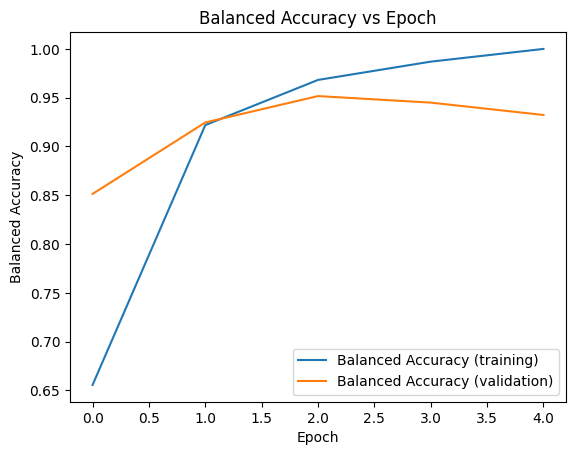

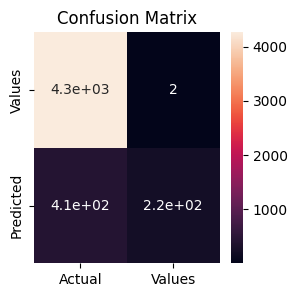

In [ ]:
# Path to ICCAD1 dataset
folder = '/content/iccad-official/iccad1/'

# Obtaining training and validation directories
train_dir, val_dir = dataset_analysis(folder)

# Obtaining training and validation data generators
train_data_gen, val_data_gen = data_extractor(train_dir, val_dir)

# Compiling custom CNN model with nadam optimizer and binary cross entropy loss function
model.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['Accuracy','Precision','Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

# Training the model for 5 epochs
history1 = model.fit(train_data_gen, epochs=5,
                     validation_data=val_data_gen)

# Visualizing the results
dummy = plot_func(history1)

Benchmark 2

The dataset contains:
5459 Training images
41796 Validation images

The training set contains:
174 Images with hotspot
5285 Images without hotspot

The validation set contains:
498 Images with hotspot
41298 Images without hotspot

Found 5459 images belonging to 2 classes.
Found 41796 images belonging to 2 classes.
Epoch 1/5
171/171 [==============================] - 298s 2s/step - loss: 0.0956 - Accuracy: 0.9679 - precision: 0.9810 - recall: 0.9860 - true_positives: 5211.0000 - true_negatives: 73.0000 - false_positives: 101.0000 - false_negatives: 74.0000 - val_loss: 0.0628 - val_Accuracy: 0.9871 - val_precision: 0.9990 - val_recall: 0.9878 - val_true_positives: 40796.0000 - val_true_negatives: 459.0000 - val_false_positives: 39.0000 - val_false_negatives: 502.0000
Epoch 2/5
171/171 [==============================] - 244s 1s/step - loss: 0.0309 - Accuracy: 0.9868 - precision: 0.9923 - recall: 0.9941 - true_positives: 5254.0000 - true_negatives: 133.0000 - false_positives: 41.0000 - fal

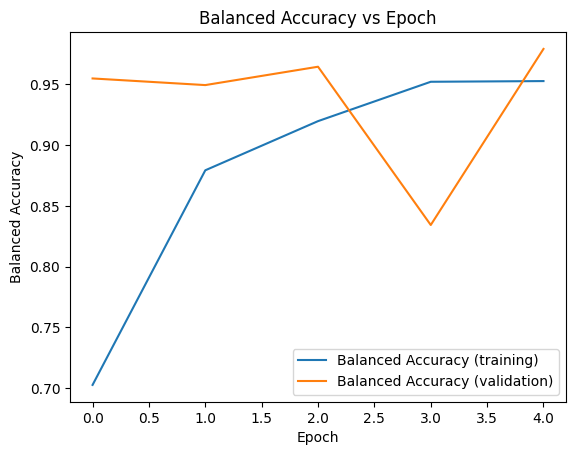

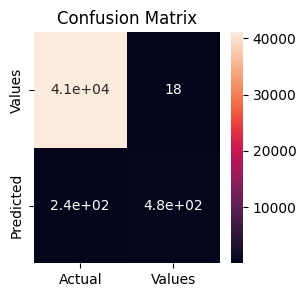

In [ ]:
# Same steps as benchmark 1 are followed

folder = '/content/iccad-official/iccad2/'

train_dir, val_dir = dataset_analysis(folder)

train_data_gen, val_data_gen = data_extractor(train_dir, val_dir)

model2.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['Accuracy','Precision','Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

history2 = model2.fit(train_data_gen, epochs=5,
                      validation_data=val_data_gen)

dummy = plot_func(history2)

Benchmark 3

The dataset contains:
5552 Training images
48141 Validation images

The training set contains:
909 Images with hotspot
4643 Images without hotspot

The validation set contains:
1808 Images with hotspot
46333 Images without hotspot

Found 5552 images belonging to 2 classes.
Found 48141 images belonging to 2 classes.
Epoch 1/10
174/174 [==============================] - 324s 2s/step - loss: 0.1047 - Accuracy: 0.9618 - precision: 0.9727 - recall: 0.9819 - true_positives: 4559.0000 - true_negatives: 781.0000 - false_positives: 128.0000 - false_negatives: 84.0000 - val_loss: 0.1235 - val_Accuracy: 0.9625 - val_precision: 0.9630 - val_recall: 0.9995 - val_true_positives: 46309.0000 - val_true_negatives: 28.0000 - val_false_positives: 1780.0000 - val_false_negatives: 24.0000
Epoch 2/10
174/174 [==============================] - 300s 2s/step - loss: 0.0340 - Accuracy: 0.9896 - precision: 0.9948 - recall: 0.9927 - true_positives: 4609.0000 - true_negatives: 885.0000 - false_positives: 24.0000 -

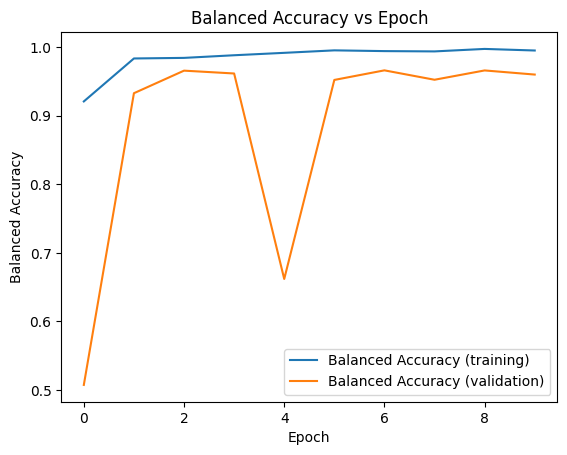

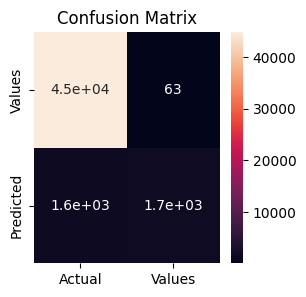

In [ ]:
# Same steps as benchmark 1 are followed, with epoch = 10 

folder = '/content/iccad-official/iccad3/'

train_dir, val_dir = dataset_analysis(folder)

train_data_gen, val_data_gen = data_extractor(train_dir, val_dir)

model3.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['Accuracy','Precision','Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

history3 = model3.fit(train_data_gen, epochs=10,
                      validation_data=val_data_gen)

dummy = plot_func(history3)

Benchmark 4

The dataset contains:
4547 Training images
32067 Validation images

The training set contains:
95 Images with hotspot
4452 Images without hotspot

The validation set contains:
177 Images with hotspot
31890 Images without hotspot

Found 4547 images belonging to 2 classes.
Found 32067 images belonging to 2 classes.
Epoch 1/10
143/143 [==============================] - 190s 1s/step - loss: 0.1208 - Accuracy: 0.9567 - precision: 0.9797 - recall: 0.9760 - true_positives: 4345.0000 - true_negatives: 5.0000 - false_positives: 90.0000 - false_negatives: 107.0000 - val_loss: 0.0346 - val_Accuracy: 0.9945 - val_precision: 0.9945 - val_recall: 1.0000 - val_true_positives: 31890.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 177.0000 - val_false_negatives: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 181s 1s/step - loss: 0.0463 - Accuracy: 0.9795 - precision: 0.9814 - recall: 0.9980 - true_positives: 4443.0000 - true_negatives: 11.0000 - false_positives: 84.0000 -

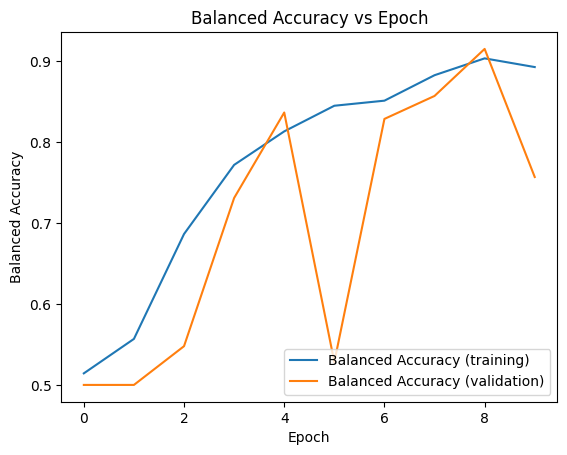

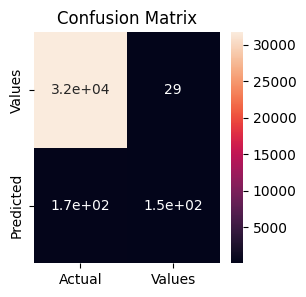

In [ ]:
# Same steps as benchmark 1 are followed, with epoch = 10 

folder = '/content/iccad-official/iccad4/'

train_dir, val_dir = dataset_analysis(folder)

train_data_gen, val_data_gen = data_extractor(train_dir, val_dir)

model4.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['Accuracy','Precision','Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

history4 = model4.fit(train_data_gen, epochs=10,
                      validation_data=val_data_gen)

dummy = plot_func(history4)

Benchmark 5

The dataset contains:
2742 Training images
19368 Validation images

The training set contains:
26 Images with hotspot
2716 Images without hotspot

The validation set contains:
41 Images with hotspot
19327 Images without hotspot

Found 2742 images belonging to 2 classes.
Found 19368 images belonging to 2 classes.
Epoch 1/10
86/86 [==============================] - 132s 1s/step - loss: 0.0757 - Accuracy: 0.9796 - precision: 0.9904 - recall: 0.9890 - true_positives: 2686.0000 - true_negatives: 0.0000e+00 - false_positives: 26.0000 - false_negatives: 30.0000 - val_loss: 0.1136 - val_Accuracy: 0.9978 - val_precision: 0.9979 - val_recall: 0.9999 - val_true_positives: 19326.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 41.0000 - val_false_negatives: 1.0000
Epoch 2/10
86/86 [==============================] - 124s 1s/step - loss: 0.0267 - Accuracy: 0.9916 - precision: 0.9920 - recall: 0.9996 - true_positives: 2715.0000 - true_negatives: 4.0000 - false_positives: 22.0000 - false_n

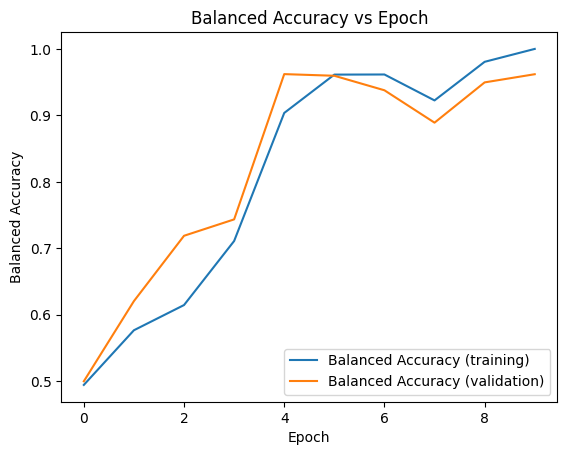

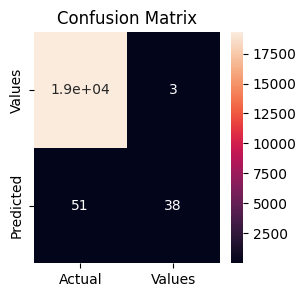

In [ ]:
# Same steps as benchmark 1 are followed, with epoch = 10 

folder = '/content/iccad-official/iccad5/'

train_dir, val_dir = dataset_analysis(folder)

train_data_gen, val_data_gen = data_extractor(train_dir, val_dir)

model5.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['Accuracy','Precision','Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

history5 = model5.fit(train_data_gen, epochs=10,
                     validation_data=val_data_gen)

dummy = plot_func(history5)

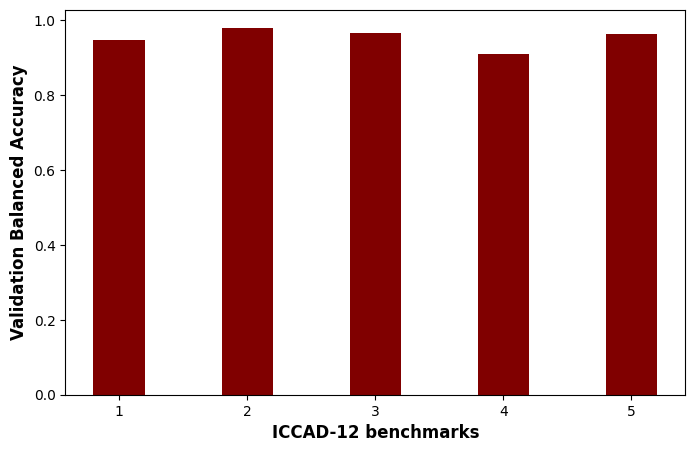

Average validation balanced accuracy of custom model =  0.953


In [ ]:
# Best validation balance accuracies obtained on each benchmark is stored
balacc = {'1':0.948, '2':0.979, '3':0.966, '4':0.910, '5':0.962}
benchmarks = list(balacc.keys())
values = list(balacc.values())
  
fig = plt.figure(figsize = (8, 5))
 
# Bar plot of balanced accuracy vs benchmark is created 
plt.bar(benchmarks, values, color ='maroon', width = 0.4)
 
plt.xlabel("ICCAD-12 benchmarks", fontweight ='bold', fontsize = 12)
plt.ylabel("Validation Balanced Accuracy", fontweight ='bold', fontsize = 12)
plt.show()

print("Average validation balanced accuracy of custom model = ", sum(values)/5)

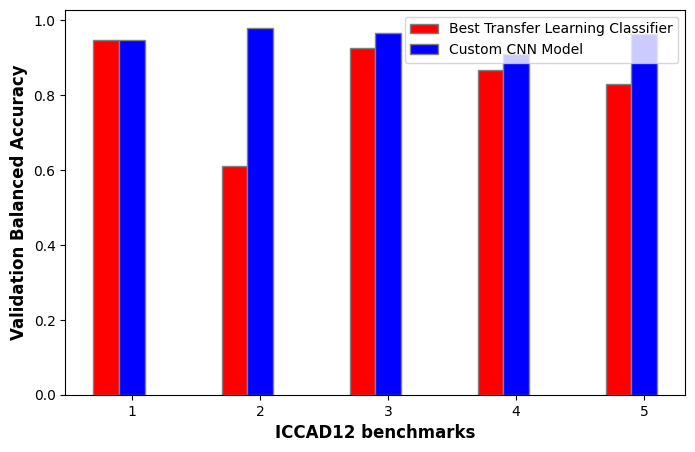

In [ ]:
# Comparision of best model obtained by transfer learning with custom CNN model using bar plot

ba_tl = {'benchmark1':0.948, 'benchmark2':0.610, 'benchmark3':0.925, 'benchmark4':0.868, 'benchmark5':0.829}
ba_cm = {'benchmark1':0.948, 'benchmark2':0.979, 'benchmark3':0.966, 'benchmark4':0.910, 'benchmark5':0.962}

bal_acc1 = list(ba_tl.values())
bal_acc2 = list(ba_cm.values())

barWidth = 0.2
fig = plt.subplots(figsize =(8, 5))

br1 = np.arange(len(bal_acc1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, bal_acc1, color ='r', width = barWidth,
        edgecolor ='grey', label ='Best Transfer Learning Classifier')
plt.bar(br2, bal_acc2, color ='b', width = barWidth,
        edgecolor ='grey', label ='Custom CNN Model')

plt.xlabel('ICCAD12 benchmarks', fontweight ='bold', fontsize = 12)
plt.ylabel('Validation Balanced Accuracy', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(bal_acc1))],
        ['1', '2', '3', '4', '5'])
 
plt.legend()
plt.show()

In [ ]:
import time
!unzip /content/gdrive/MyDrive/iccad_inference_test.zip -d /content/

In [ ]:
# To measure inference time of custom CNN model on random 200 images

image_gen = ImageDataGenerator(rescale=1./255)

data_gen = image_gen.flow_from_directory(directory='/content/iccad_inference_test',
                                         batch_size=32,
                                         shuffle=False,
                                         target_size=(224, 224),
                                         class_mode='binary')

number_of_examples = len(data_gen.filenames)

start_time = time.time()
model.predict(data_gen)
end_time = time.time()
duration = end_time - start_time
print("Inference time = ", duration, "s")
print("Number of predictions = ", number_of_examples)

print("Average inference time per classification = ", duration/number_of_examples, "s")

Found 200 images belonging to 2 classes.
7/7 [==============================] - 1s 143ms/step
Inference time =  1.262321949005127 s
Number of predictions =  200
Average inference time per classification =  0.006311609745025635 s


**References** </br>
1) V. Borisov and J. Scheible, "Lithography Hotspots Detection Using Deep Learning," 2018 15th International Conference on Synthesis, Modeling, Analysis and Simulation Methods and Applications to Circuit Design (SMACD), Prague, Czech Republic, 2018, pp. 145-148, doi: 10.1109/SMACD.2018.8434561. </br>
2) https://www.tensorflow.org/ </br>
3) https://github.com/sumedhachugh/Lithography-Hotspot-Detection </br>
4) https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/ </br>
5) https://www.geeksforgeeks.org/bar-plot-in-matplotlib/